# Patch Prediction Models

<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/master/examples/example_patchprediction.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/example_patchprediction.ipynb" target="_blank"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/></a>

_Please note that if you are selecting Kaggle badge, in the Kaggle notebook you have to login and enable the internet connection from the setting panel on the right in order to install tiatoolbox from the internet._

_For faster responses you should enable the use of GPU for this session through (menu) Runtime ⟶ Change runtime type ⟶ Set "Hardware Accelator" to "GPU"._

## About this notebook


This  jupyter notebook can be run on any computer with a standard browser (preferably the latest version of Google Chrome) and no programming language installation is required. It can run be remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on the badge "Open in Colab" above. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on either Github or colab, so you cannot inadvertently mess it up, and you should feel free to experiment. Use the notebook's File Menu if you wish to save your own (changed) notebook.

Before running the notebook outside Colab, set up your Python environment, as explained in the 
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

## Welcome to Tiatoolbox

In this example we will show how to use tiatoolbox for patch-level prediction using a range of deep learning models. Tiatoolbox can be used to make predictions on pre-extracted image patches or on larger image tiles / whole-slide images (WSIs), where image patches are extracted on the fly. WSI Patch-level predictions can subsequently be aggregated to obtain a segmentation map. In particular, we will introduce the use of our module
`patch_predictor` ([details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/models/classification/patchextraction.py)). A full list of the available models trained and provided in tiatoolbox for patch-level prediction are given below:

- Models trained on the Kather 100k dataset ([details](https://zenodo.org/record/1214456#.YJw4UEhKjvU)):
    - `alexnet-kather100k`
    - `resnet18-kather100k`
    - `resnet34-kather100k`
    - `resnet50-kather100k`
    - `resnet101-kather100k`
    - `resnext50_32x4d-kather100k`
    - `resnext101_32x8d-kather100k`
    - `wide_resnet50_2-kather100k`
    - `wide_resnet101_2-kather100k`
    - `densenet121-kather100k`
    - `densenet161-kather100k`
    - `densenet169-kather100k`
    - `densenet201-kather100k`
    - `mobilenet_v2-kather100k`
    - `mobilenet_v3_large-kather100k`
    - `mobilenet_v3_small-kather100k`
    - `googlenet-kather100k`

### First cell in bash
This cell prepares the Colab environment for the use of `tiatoolbox`. This cell produces no output if it has been run before in the same Colab session. Skip this cell, if using the notebook outside Colab or Kaggle and you already have tiatoolbox installed. 

In [1]:
!apt-get -y -qq install libopenjp2-7-dev libopenjp2-tools openslide-tools
!pip install --quiet -U git+https://github.com/TIA-Lab/tiatoolbox@feature-patchwsi
print('Installation is complete.')

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Installation is complete.


## Importing related libraries
We will start by importing some libraries required to run this notebook.

In [2]:
from tiatoolbox.models.classification import CNNPatchPredictor
from tiatoolbox.models.dataset import PatchDataset
from tiatoolbox.utils.misc import imread, get_pretrained_model_info, grab_files_from_dir
from tiatoolbox.utils.visualisation import visualise_patch_prediction
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

mpl.rcParams['figure.dpi'] = 200 # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, a WSI for our experiment. Downloading is needed once in each Colab session and it should take less than 1 minute.
> In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 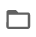

In [3]:
import requests

img_file_name = "sample_tile.png"
wsi_file_name = "sample_wsi.svs"

# Downloading sample image tile
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/CRC-Prim-HE-05_APPLICATION.tif")
with open(img_file_name, "wb") as f:
    f.write(r.content)

# Downloading sample image tile
r = requests.get("http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1-Small-Region.svs")
with open(wsi_file_name, "wb") as f:
    f.write(r.content)

# Use a tool called wget to download the dataset of 7000 images
! wget https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip
# Unzip it!
# (-o = overwrite if needed, -q = be quiet i.e. don't print out lots of unnecessary things)
! unzip -o -q kather100k-validation-sample.zip

print('Download is complete.')

--2021-05-18 12:13:11--  https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip
Resolving tiatoolbox.dcs.warwick.ac.uk (tiatoolbox.dcs.warwick.ac.uk)... 137.205.117.139
Connecting to tiatoolbox.dcs.warwick.ac.uk (tiatoolbox.dcs.warwick.ac.uk)|137.205.117.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233514161 (223M) [application/zip]
Saving to: ‘kather100k-validation-sample.zip’

kather100k-validati 100%[===================>] 222.70M   111MB/s    in 2.0s    

2021-05-18 12:13:13 (111 MB/s) - ‘kather100k-validation-sample.zip’ saved [233514161/233514161]

Download is complete.


# Get predictions for a set of patches

Below we will demonstrate how to use tiatoolbox to obtain the model predictions for a set of patches with a pretrained model.

For this demonestration, we are going to use patches from the validation subset of [Kather100K](https://zenodo.org/record/1214456#.YJ-tn3mSkuU) dataset. This dataset has already been downloaded in the download section above. We first should read the image list and their classes for the process. Code in the cell below looks into the downloaded dataset and saves the path of each image in a list. Also, class of the each image is the same as the subfolder it is located in.

In [12]:
# generate list of class names based on subfolder names in the dataset

dataset_path = './kather100k-validation-sample/' # set the path to the dataset
image_ext = '.tif'  # file extention of each image

# obtain the mapping between the label ID and the label name
label_dict = {'ADI':0, 'BACK':1, 'DEB':2, 'LYM':3, 'MUC':4, 'MUS':5, 'NORM':6, 'STR':7, 'TUM': 8}
class_names = label_dict.keys()
    
# generate a list of patches and generate the label from the filename
patch_list = grab_files_from_dir(dataset_path, file_types='*'+image_ext)
label_list = []
for patch_filename in patch_list:
    patch_basename = os.path.basename(patch_filename)
    class_name = patch_basename.split('-')[0]
    label_list.append(label_dict[class_name])


# show some dataset statistics
# count the number of examples per class
for class_name, label in label_dict.items():
    print('Class ID: {} -- Class Name: {} -- Number of images: {}'.format(
        label, class_name, label_list.count(label)
    ))
    

# overall dataset statistics
print('Total number of patches: {}'.format(len(patch_list)))

Class ID: 0 -- Class Name: ADI -- Number of images: 208
Class ID: 1 -- Class Name: BACK -- Number of images: 211
Class ID: 2 -- Class Name: DEB -- Number of images: 230
Class ID: 3 -- Class Name: LYM -- Number of images: 232
Class ID: 4 -- Class Name: MUC -- Number of images: 178
Class ID: 5 -- Class Name: MUS -- Number of images: 270
Class ID: 6 -- Class Name: NORM -- Number of images: 176
Class ID: 7 -- Class Name: STR -- Number of images: 209
Class ID: 8 -- Class Name: TUM -- Number of images: 286
Total number of patches: 2000


As you can see for this patch dataset, we have 9 classes with IDs 0-8 and class names describing different types of tissue in the patch:
- BACK ⟶ Background (empty glass region)
- LYM  ⟶ Lymphocytes
- NORM ⟶ Normal colon mucosa
- DEB  ⟶ Debris
- MUS  ⟶ Smooth muscle
- STR  ⟶ Cancer-associated stroma
- ADI  ⟶ Adipose
- MUC  ⟶ Mucus 
- TUM  ⟶ Colorectal adenocarcinoma epithelium

It is easy to use this code for your dataset. You only need to change the path to your dataset, make sure you dataset is arranged like this example (images of different classes are placed into different subfolders), and set the right image extension in the `image_ext` variable. 

## Predict patch labels in 2 lines of code
Now that we have the list of images that we want to predict, we can use tiatoolbox's `CNNPatchPredictor` to do that. First, we instantiate a predictor object and then we call the `predict` method to get the results:

In [13]:
predictor = CNNPatchPredictor(pretrained_model='resnet18-kather100k', batch_size=8)
output = predictor.predict(img_list=patch_list, mode='patch', return_probabilities=True)

  0%|                                                   | 0/250 [00:00<?, ?it/s]|2021-05-18|12:16:24.155| [WARNING] /home/simon/anaconda3/envs/tiatoolbox/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))

100%|#########################################| 250/250 [00:03<00:00, 67.93it/s]


Patch Prediction is Done!

The first line creates a CNN-based patch classifier instance based on the passed arguments and prepare a CNN model (generate the network, download pretrained weights, etc.). The CNN model used in this predictor can be set using the `pretrained_model` argument. A complete list of supported pretrained classification models that have been trained on Kather 100K dataset, is reported in the first section of this notebook example. However, `CNNPatchPredictor` enables you to use your own pre-trained models for your specific classification applicaion. In order to do that, you might need to change some input arguments to the `CNNPatchPredictor` as explained below:
- `model`: Use externally defined PyTorch model for prediction with weights already loaded. This is useful when you want to use your own pre-trained model on you specific data. The only contraint is that the input model should be of `torch.nn.Module` type, i.e. generated using Pytorch.
- `predefined_model `: You are already familiar with this argument. Using this argument, you tell tiatoolbox to use one of its pre-trained models for the prediction task. A complete list of pre-trained models can be found [here](_link_to_somewhere_related_). Note that if you pass a `model` argument to the class, then `CNNPatchPredictor` would use the input `model` and neglect `predefined_model`. In this example, we used `resnet18-kather100K` which mean the model architecture is 18 layer ResNet that has been trained Kather100K dataset.
- `pretrained_weight`: When you are using a `predefined_model`, the corresponding pretrained weights will also be downloaded by default.  However, you can override with your own set of weights via the `pretrained_weight` argument.
- `batch_size`: Number of images fed into the model each time. Higher values for this parameter requires you to have a GPU with higher memory capacity (if you are using GPU for the computations). 


The second line in the snippet above calls the `predict` method to apply the CNN on the input patches and get the results. Here are some important `predict` input arguments and their descriptions:
- `mode`: Type of input to process. Choose from either `patch`, `tile` or `wsi` based on your application. In this example, we are predicting type of histology patches so we used `patch` option. We will explain the use of `tile` and `wsi` options in the next sections.
- `img_list`: List of inputs to process. When using`patch` mode, the input must be either a list of images, a list of image file paths or a numpy array of an image list. 
- `return_probabilities`: If you would like to have per-class probabilities alongside predicted labels of input patches, you should set this option as true.

In the `patch` prediction mode, the `predict` method returns an output dictionary which contains the `predictions` (predicted labels) and `probabilities` that is a list class probabilities for each input patch.

The cell below uses common python tools to visualize the patch classification results in terms of classifcation accuracy and confusion matrix.

Classification accuracy: 0.99


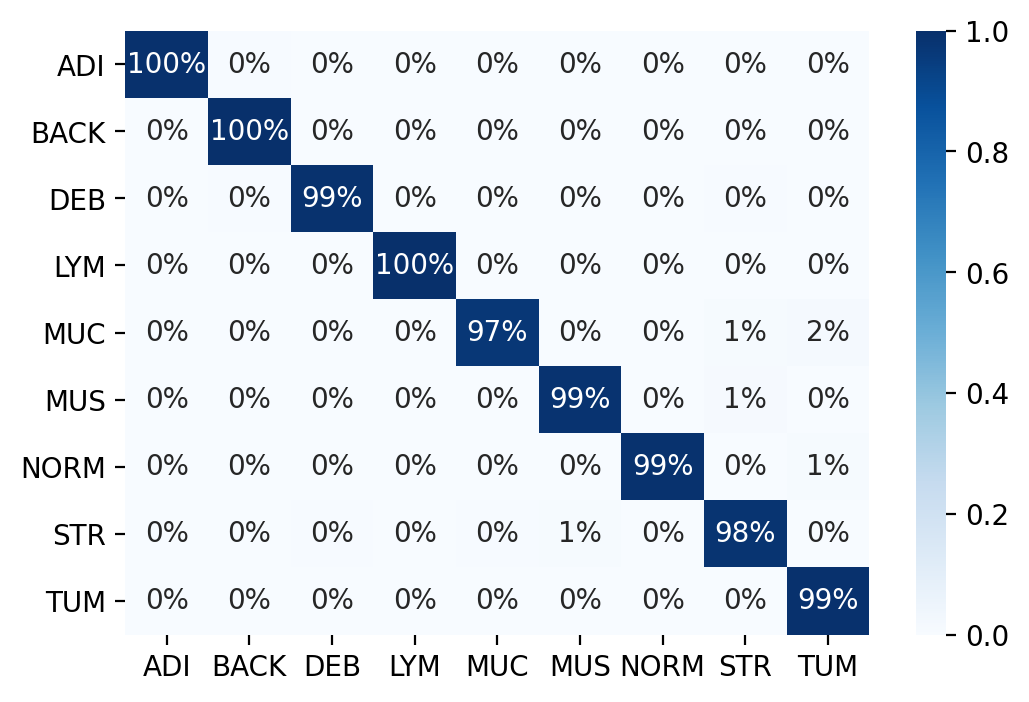

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

acc = accuracy_score(label_list, output['predictions'])
print('Classification accuracy: {}'.format(acc))
# Creating and visualizing the confusion matrix for patch classification results
conf = confusion_matrix(label_list, output['predictions'], normalize='true')
df_cm = pd.DataFrame(conf, index = class_names, columns = class_names)
sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.0%')
plt.show()

Now, you can try by changing the `pretrained_model` argument when making `CNNPatchPredictor` instant and see how it can affect the classification output accuracy.

# Get predictions for patches within an image tile

We will now demonstrate how to obtain patch-level predictions for a large image tile. It is quite a common practice in computational pathology to partion a large image into several patches (often overlapping) and then aggregate the results to generate a prediction map for different regions of the large image. As we are predicting on patch-level again. there is no need to instantiate a new `CNNPatchPredictor` class. However, we should tune the `predict` input arguments to make it suitable for tile prediction. The `predict` function then automatically extract patches from the large image tile and predict the label for each of them. As the `perdict` function can accept multiiple tiles in the input to process and each input tile has several patches, the results of `predict` function would be save in a file rather than returned as the function output. This is done to avoid having huge output objects which mat cause memory errors.

Now, enough of thechinal talks! Let's try this function on a sample tile. For this example, we use a tile that has been release with the [Kather et al. 2016](https://doi.org/10.1038/srep27988) paper. It has been already dowloaded in the Download section of this notebook, let's have look at it.

Tile size is: (5000, 5000, 3)


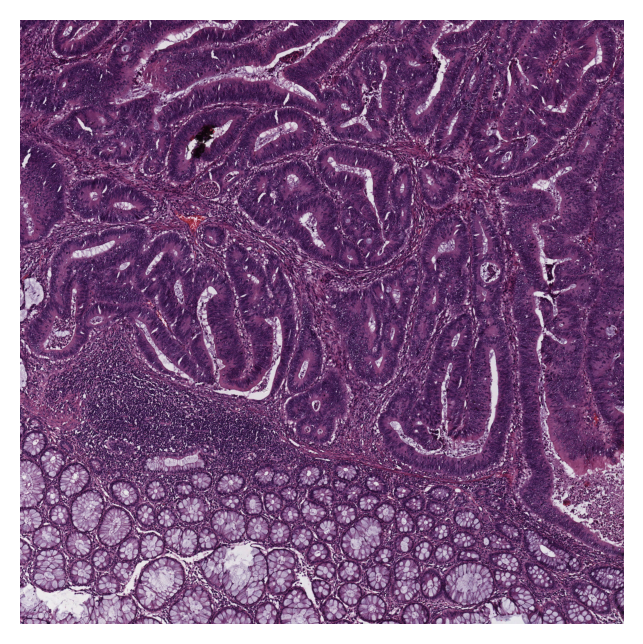

In [15]:
input_tile = imread(img_file_name)
plt.imshow(input_tile)
plt.axis('off')
print('Tile size is: {}'.format(input_tile.shape))

## Patch-level prediction for big histology tiles in 2 lines of code
As you can see the size of the tile image is 5000x5000 pixels, which is quite big for a CNN input image. But the `predict` method of `CNNPatchPredictor` handles this big tile easily. You only need to change the `mode` argument to `tile` and a couple of other arguments, which will be explained shortly.

In [16]:
predictor = CNNPatchPredictor(pretrained_model='resnet18-kather100k', batch_size=64)
tile_output = predictor.predict(img_list=[img_file_name], mode='tile',
                           patch_size=[224, 224], stride_size=[28,28], return_probabilities=True)

# this faces error if in the input I put: [img_file_name, img_file_name]

|2021-05-18|12:16:51.781| [WARNING] /home/simon/anaconda3/envs/tiatoolbox/lib/python3.7/site-packages/tiatoolbox/models/dataset/classification.py:247: UserWarning: WSIPatchDataset only read tile at `units="baseline"` and `resolution=1.0`.
  "WSIPatchDataset only read tile at "

|2021-05-18|12:16:52.382| [WARNING] /home/simon/anaconda3/envs/tiatoolbox/lib/python3.7/site-packages/tiatoolbox/wsicore/wsimeta.py:155: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

100%|#########################################| 457/457 [01:18<00:00,  5.80it/s]


The new arguments in the input of `predict` method are:
- `mode='tile'`: Naturally, because we want to predict on a big tile this time!
- `img_list`: _Note that_ in tile mode, the input can only be be a list of file paths.
- `save_dir`:  Output directory when processing multiple tiles. We explained before why this is necessary when we are working on multiple big tiles.
- `patch_shape`: as the name suggests, this parameter sets the size of patches (in [H, W] format) to be extracted from the input tiles for which the labels will be predicted.
- `stride_shape`: The stide (in [H, W] format) to consider when extracting patches from the tile. Smaller strides mean having more overlaps between consecutive patches.
- `label_list`: (optional) a list of labels with same size as `img_list` that refers to the labels of input tiles as a whole (not to be confused with the predition of each patch).

In this example, we used only one tile in the input therefore the toolbox does not save the output as files and instead return a list which contains output dictionary with the following keys:
- `coordinates`: list of extract patches' coordinates in the follwoing format: `[x_min, y_min, x_max, y_max]`. These coordinates can be used to extract the same region from the input tile/wsi or regenrete a prediction map based on the `prediction` labels for each patch.
- `predictions`: list of predicted labels for tile's patches.
- `label`: Label of the tile generalized to each patch.
Keep in mind that if we had several items in the `img_list` input, then real result would be save in JSON format on the specified `save_dir` and the `tile_output` that predict method return is only a list of paths referring to the save JSON files.

Now, let's try and visulize some patch-level results:

In [ ]:
# what is the format of coordinates
coordinates = tile_output[0]['coordinates']
predictions = tile_output[0]['predictions']
random_idx = np.random.randint(0 , len(predictions), (4,))
for i, idx in enumerate(random_idx):
  this_coord = coordinates[idx]
  this_prediction = predictions[idx]
  for class_name, label in label_dict.items():
    if label == this_prediction:
        predicted_class = class_name
  this_patch = input_tile[this_coord[0]: this_coord[2], this_coord[1]: this_coord[3]]
  plt.subplot(2,2,i+1), plt.imshow(this_patch)
  plt.axis('off')
  plt.title(class_name)

Results for 4 random patches are from the tile are show here. However, there is a more interesting way of visualizing patch-level prediction form tiles and it is thtough `????` funtionality of tiatoolbox. You easily pass the the predictor output to this function and it generates a prediction map.

In [ ]:
# visualization of image tile patch-level prediction

overlay, pred_map = visualise_patch_prediction([img_file_name], tile_output, mode='tile', tile_resolution=20.0, resolution=1.25)

plt.subplot(1,2,1)
plt.imshow(pred_map)
plt.title('Overlay')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title('Prediction Map')
plt.axis('off')
plt.show()

You can now go back and try predicting with different `stride_size` or `pretrained_model` values and visualize the effect of changes on the prediction map.

# Get predictions for patches within a WSI

We will now demonstrate how to obtain predictions for all patches within a whole-slide image. Similar to previous sections, we will use `CNNPatchPredictor` and its `predict` method, but this time we set the `mode` to `wsi`, as below:

In [ ]:
predictor = CNNPatchPredictor(pretrained_model='resnet18-kather100k', batch_size=64)
wsi_output = predictor.predict([wsi_file_name],
                           mask_list=[None],
                           mode='wsi',
                           patch_size=(224,224),
                           stride_size=(24,24),
                           resolution=1.0,
                           units="baseline",
                           return_probabilities=True)
############ I suggest if None is passed for masks, we generate tissue mask using wsi.tissue_mask() function instead of extracting labels for all regions (or maybe accept an argument for that option).

There are some new arguments introduced in this `predictor.predict` example which are:
- `mode`: should be set to 'wsi' when analysing whole slide images.
- `resolution` and `unit`: These arguments specify the level or micron-per-pixel resolution of the WSI levels from which we plan to extract patches. Here we specify the WSI's level to "basedline" which is equivalent to level 0. In general, this is the level of greatest resolution, although, in this particular case, the image has only one level. More information can be found in the [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=WSIReader.read_rect#tiatoolbox.wsicore.wsireader.WSIReader.read_rect). 
- `mask_list`: A list of paths correspond to the masks of WSIs in the `img_list`. These masks specify the regions in the oringal WSIs that we desire to extract patches from. If a `None` value is passed for a WSI, then the labels for all patches of that WSI (even backgournd regions) would be predicted, which may cause unnecessary computational overhead when working on whole slide images.

Now, let's see how that prediction model worked on our input WSI regions:

In [ ]:
# visualization of whole-slide image patch-level prediction

overlay, pred_map = visualise_patch_prediction([wsi_file_name], wsi_output, mode='wsi', resolution=1.25)

plt.subplot(1,2,1)
plt.imshow(pred_map)
plt.title('Overlay')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title('Prediction Map')
plt.axis('off')
plt.show()